In [67]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from src.classes import BallAnomaly, HitBox, TankProperties32x2
from src.dataprocessing import (
    get_BallAnomaly_properties,
    get_measured_potential,
    get_permarray_FF,
    get_pot_data_FF,
    get_sample,
)
from src.functions import (
    compute_hitbox,
    create_meas_coordinates,
    create_mesh,
    print_coordinates_props,
    set_perm,
)
from src.ML_example import init_train_data
from src.visualization import plot_meas_coords, plot_mesh
from tqdm import tqdm

## Generate Synthetic VAE data

In [68]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, d=30, perm=10, material="acryl")
hitbox = compute_hitbox(tank, ball, safety_tolerance=10.0)
hitbox.z_min = tank.E_zr1 - ball.d / 4
hitbox.z_max = tank.E_zr2 + ball.d / 4
coordinates = create_meas_coordinates(hitbox, x_pts=25, y_pts=25, z_pts=20)

HitBox(x_pts,y_pts,z_pts) leads to 8820 available points.
So 8820 points will be measured.


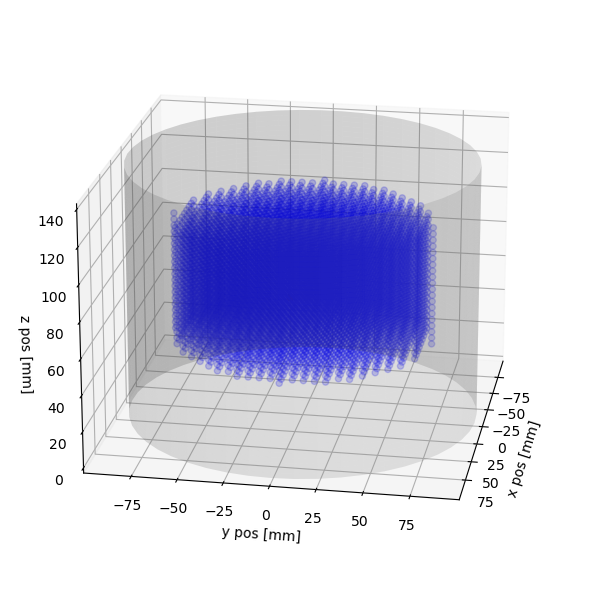

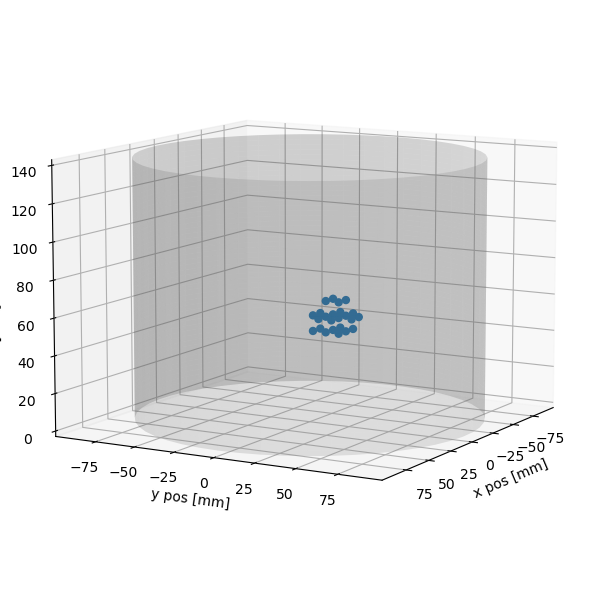

In [69]:
sel_coor_test = 3200
plot_meas_coords(tank=tank, meas_coords=coordinates, p_select=sel_coor_test)
ball.x, ball.y, ball.z = coordinates[sel_coor_test]
# create an empty mesh
mesh_obj = create_mesh(tank, h0=0.125)
set_perm(mesh_obj, anomaly=ball)
# plot mesh
plot_mesh(mesh_obj, tank)

In [47]:
Perms = list()

# for _ in range(1):
for XYZ in coordinates[::4, :]:
    # update ball position
    ball.x, ball.y, ball.z = XYZ
    mesh_obj = set_perm(mesh_obj, ball)
    Perms.append(mesh_obj.perm_array)  # + np.random.random(3542)
Perms = np.array(Perms)
Perms = Perms / 15

Perms_train = Perms
np.random.shuffle(Perms_train)
print(Perms_train.shape, np.min(Perms_train), np.max(Perms_train))

(2205, 6936) 0.06666666666666667 0.6666666666666666


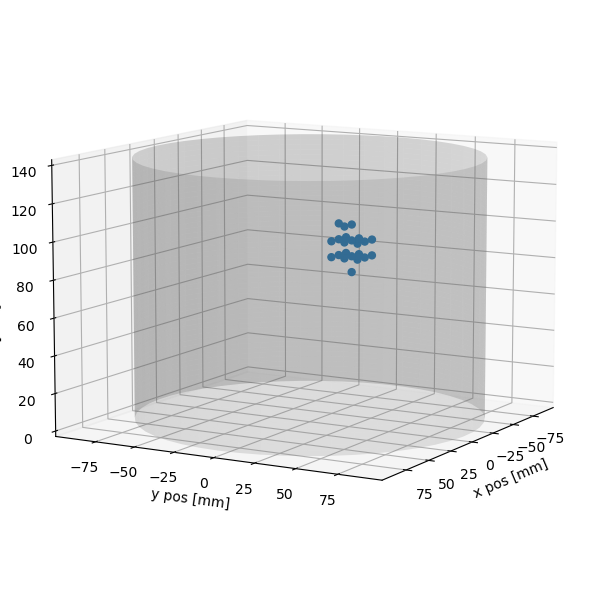

In [66]:
mesh_obj.perm_array = Perms_train[10, :]*15
plot_mesh(mesh_obj)

In [56]:
import tensorflow as tf
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

latent_dim = 8


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    #axis=1,
                    # keras.losses.mean_absolute_error(data, reconstruction)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = (
                reconstruction_loss + 0.8 * kl_loss
            )  # <- tune the interpolation characteristics
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [57]:
def encoder_model(inp_shape=(6936,), latent_dim=latent_dim):
    encoder_inputs = keras.Input(shape=inp_shape)
    x = layers.Reshape((6936, 1))(encoder_inputs)
    x = layers.ZeroPadding1D((264, 0))(x)
    x = layers.Conv1D(4, activation="relu", kernel_size=6, strides=2, padding="same")(x)
    x = layers.Conv1D(4, activation="relu", kernel_size=6, strides=2, padding="same")(x)
    x = layers.Conv1D(8, activation="relu", kernel_size=6, strides=3, padding="same")(x)
    x = layers.Conv1D(8, activation="relu", kernel_size=6, strides=2, padding="same")(x)
    x = layers.Conv1D(16, activation="relu", kernel_size=6, strides=3, padding="same")(
        x
    )
    x = layers.Conv1D(16, activation="relu", kernel_size=6, strides=5, padding="same")(
        x
    )
    x = layers.Flatten()(x)
    # x = layers.Dense(160, activation="relu")(x)
    # x = layers.Dense(64, activation="relu")(x)
    # x = layers.Dense(16, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling(name="z")([z_mean, z_log_var])

    return encoder_inputs, z_mean, z_log_var, z


def decoder_model(latent_dim=latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")

    # x = layers.Dense(16, activation="relu")(latent_inputs)
    # x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(320, activation="relu")(latent_inputs)
    x = layers.Reshape((20, 16))(x)

    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=6, strides=5, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=6, strides=3, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        8, activation="relu", kernel_size=6, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        4, activation="relu", kernel_size=6, strides=3, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        4, activation="relu", kernel_size=6, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        1, activation="sigmoid", kernel_size=6, strides=2, padding="same"
    )(x)

    x = layers.Cropping1D(cropping=(264, 0))(x)
    decoder_outputs = layers.Flatten()(x)

    return latent_inputs, decoder_outputs


def vae_model():
    encoder_inputs, z_mean, z_log_var, z = encoder_model()
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")
    encoder.summary()

    decoder_inputs, decoder_outputs = decoder_model()
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
    decoder.summary()

    return VAE(encoder, decoder)


vae = vae_model()

Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 6936)]               0         []                            
                                                                                                  
 reshape_25 (Reshape)        (None, 6936, 1)              0         ['input_14[0][0]']            
                                                                                                  
 zero_padding1d_13 (ZeroPad  (None, 7200, 1)              0         ['reshape_25[0][0]']          
 ding1D)                                                                                          
                                                                                                  
 conv1d_78 (Conv1D)          (None, 3600, 4)              28        ['zero_padding1d_13[

In [58]:
vae.compile(Adam(), loss=tf.losses.binary_crossentropy)
history = vae.fit(Perms_train, epochs=100, batch_size=100)

Epoch 1/100
23/23 [==============================] - 3s 39ms/step - loss: 68.6219 - reconstruction_loss: 65.5855 - kl_loss: 1.9288e-04
Epoch 2/100
23/23 [==============================] - 1s 37ms/step - loss: 65.2803 - reconstruction_loss: 60.9844 - kl_loss: 0.0203
Epoch 3/100
23/23 [==============================] - 1s 34ms/step - loss: 46.3456 - reconstruction_loss: 36.3972 - kl_loss: 1.6834
Epoch 4/100
23/23 [==============================] - 1s 35ms/step - loss: 27.2514 - reconstruction_loss: 25.7171 - kl_loss: 0.0936
Epoch 5/100
23/23 [==============================] - 1s 33ms/step - loss: 25.8679 - reconstruction_loss: 24.7872 - kl_loss: 0.0045
Epoch 6/100
23/23 [==============================] - 1s 33ms/step - loss: 25.5719 - reconstruction_loss: 24.5501 - kl_loss: 0.0138
Epoch 7/100
23/23 [==============================] - 1s 35ms/step - loss: 25.4354 - reconstruction_loss: 24.4578 - kl_loss: 0.0112
Epoch 8/100
23/23 [==============================] - 1s 35ms/step - loss: 25.37

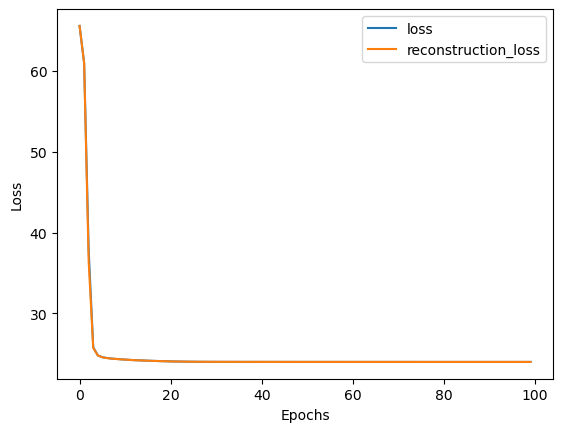

In [59]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 34ms/step


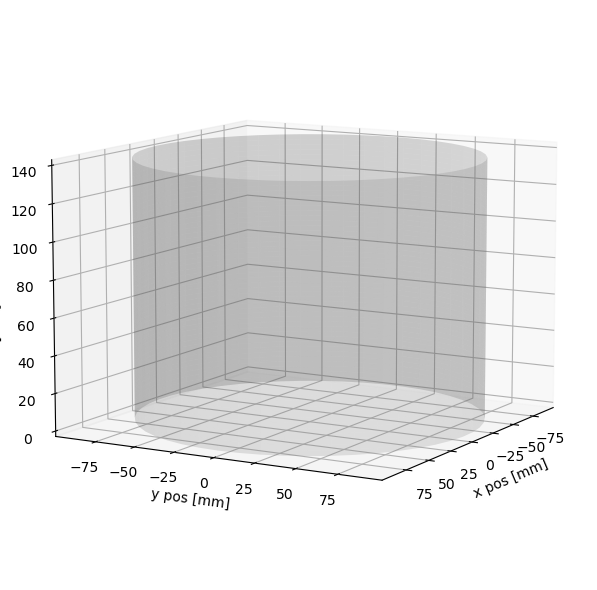

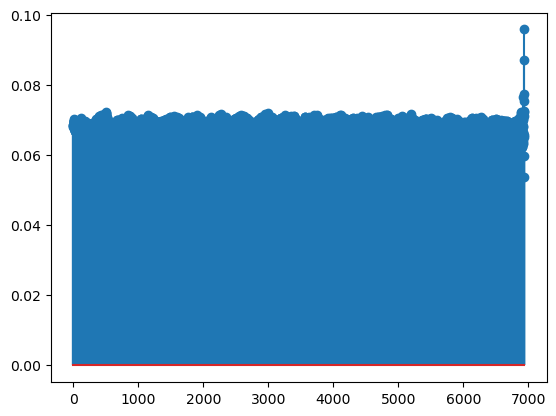

In [62]:
test_pred = vae.decoder.predict(np.expand_dims(np.random.rand(latent_dim), axis=0))
test_pred = np.concatenate(test_pred)
mesh_obj.perm_array = test_pred
plot_mesh(mesh_obj)
plt.stem(mesh_obj.perm_array)
plt.show()

## Load experimental data

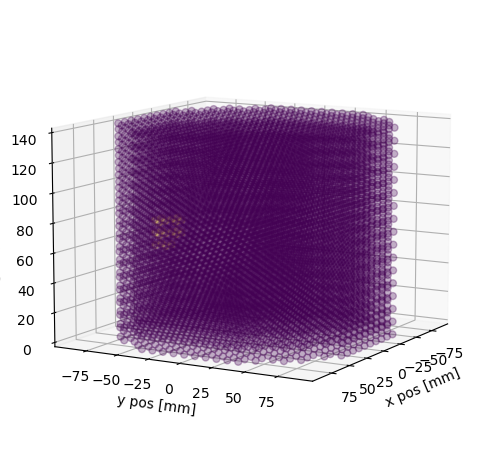

In [55]:
l_path = "measurements/acryl_skip_8_d_30/"

tmp, _ = get_sample(l_path, 17)

tank = tmp["tank"].tolist()
anomaly = get_BallAnomaly_properties(tmp)

mesh_obj = create_mesh(TankProperties32x2(), h0=0.125)
mesh_obj = set_perm(mesh_obj, anomaly)

plot_mesh(mesh_obj, elev=10)

In [56]:
anomaly

BallAnomaly(x=0.0, y=-72.0, z=64.2, d=30, perm=10, material='acryl')

In [70]:
num_samples = len(os.listdir(l_path + "data/"))

potentials = list()
perm_array = list()

for idx in tqdm(range(num_samples)):
    potentials.append(get_pot_data_FF(l_path, idx))
    perm_array.append(get_permarray_FF(l_path, idx, h0=0.125))
potentials = np.array(potentials)
perm_array = np.array(perm_array)

100%|██████████| 7450/7450 [01:45<00:00, 70.31it/s]


In [71]:
print(potentials.shape, perm_array.shape)

(7450, 4096) (7450, 6936)


In [72]:
_, _, train_z = vae.encoder.predict(perm_array)

233/233 [==============================] - 1s 3ms/step


In [73]:
Pots_train = potentials

In [74]:
def mapper(input_shape=(4096,), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.Reshape((4096, 1))(mapper_inputs)
    x = layers.Conv1D(128, strides=2, kernel_size=6)(x)
    x = layers.Conv1D(64, strides=4, kernel_size=6)(x)
    x = layers.Conv1D(32, strides=4, kernel_size=6)(x)
    x = layers.Conv1D(16, strides=4, kernel_size=6)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(mapper_inputs, x)


mapper = mapper()
mapper.compile(Adam(), loss=tf.keras.losses.mean_squared_error)
mapper.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 4096)]            0         
                                                                 
 reshape_15 (Reshape)        (None, 4096, 1)           0         
                                                                 
 conv1d_46 (Conv1D)          (None, 2046, 128)         896       
                                                                 
 conv1d_47 (Conv1D)          (None, 511, 64)           49216     
                                                                 
 conv1d_48 (Conv1D)          (None, 127, 32)           12320     
                                                                 
 conv1d_49 (Conv1D)          (None, 31, 16)            3088      
                                                                 
 flatten_15 (Flatten)        (None, 496)               0   

In [75]:
history_mapper = mapper.fit(Pots_train, train_z, epochs=150, batch_size=64)

Epoch 1/150
117/117 [==============================] - 2s 7ms/step - loss: 384.8326
Epoch 2/150
117/117 [==============================] - 1s 7ms/step - loss: 378.2498
Epoch 3/150
117/117 [==============================] - 1s 7ms/step - loss: 378.5194
Epoch 4/150
117/117 [==============================] - 1s 7ms/step - loss: 378.3504
Epoch 5/150
117/117 [==============================] - 1s 7ms/step - loss: 378.3392
Epoch 6/150
117/117 [==============================] - 1s 7ms/step - loss: 378.0752
Epoch 7/150
117/117 [==============================] - 1s 7ms/step - loss: 378.6121
Epoch 8/150
117/117 [==============================] - 1s 7ms/step - loss: 378.1151
Epoch 9/150
117/117 [==============================] - 1s 7ms/step - loss: 377.8412
Epoch 10/150
117/117 [==============================] - 1s 7ms/step - loss: 377.7671
Epoch 11/150
117/117 [==============================] - 1s 7ms/step - loss: 377.7819
Epoch 12/150
117/117 [==============================] - 1s 7ms/step - loss

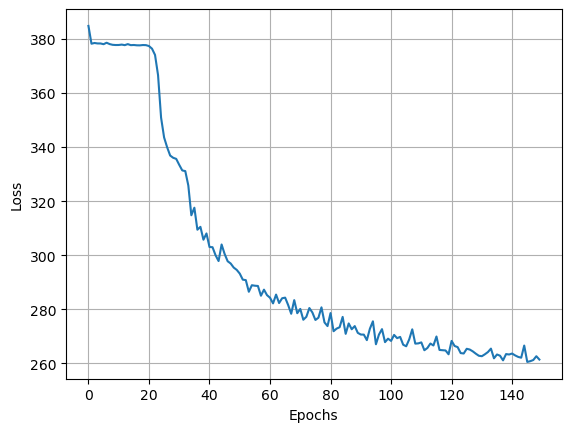

In [76]:
plt.plot(history_mapper.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [77]:
Perm_pred = vae.decoder.predict(mapper.predict(Pots_train)) * 15

233/233 [==============================] - 0s 2ms/step


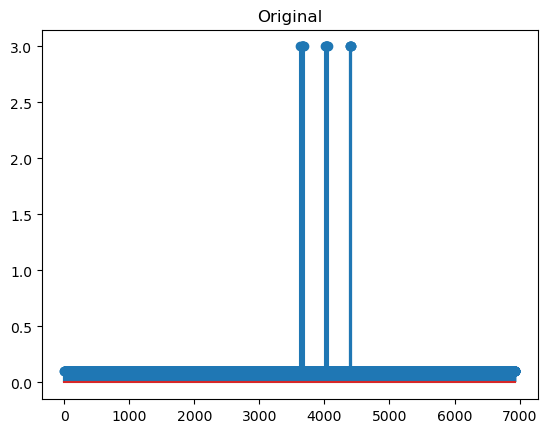

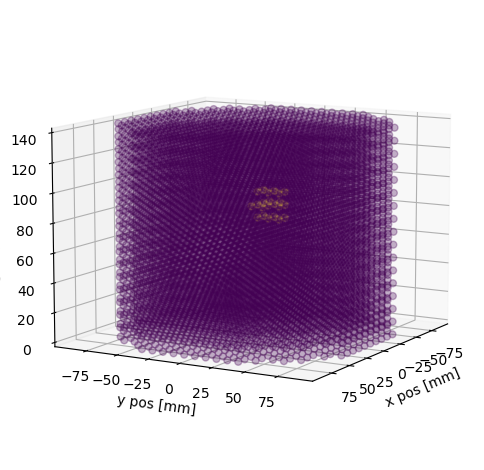

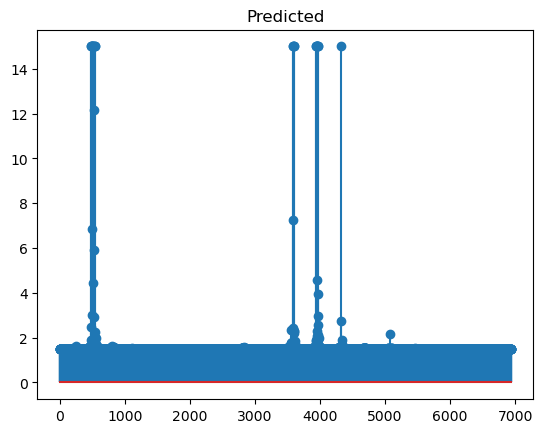

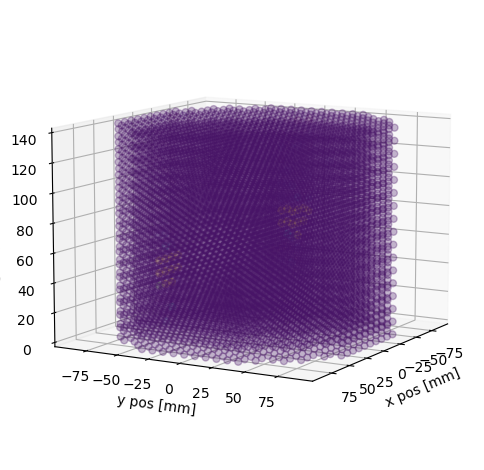

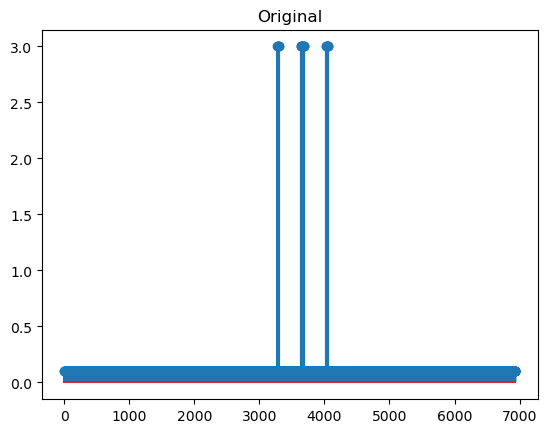

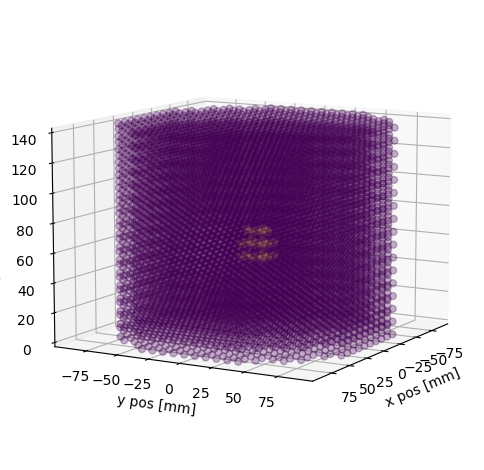

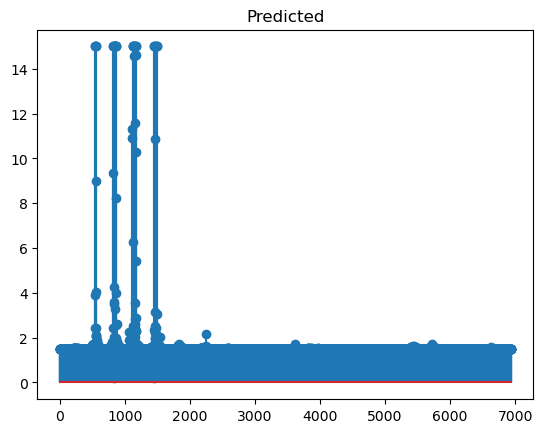

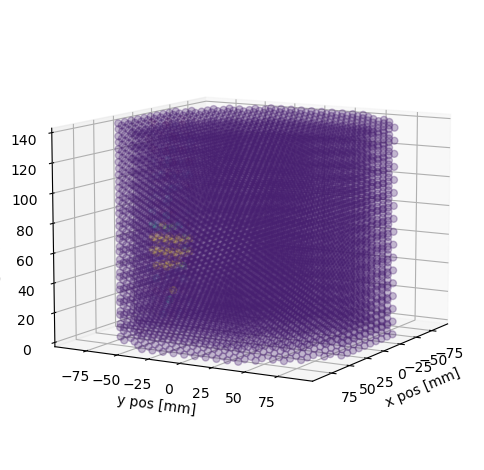

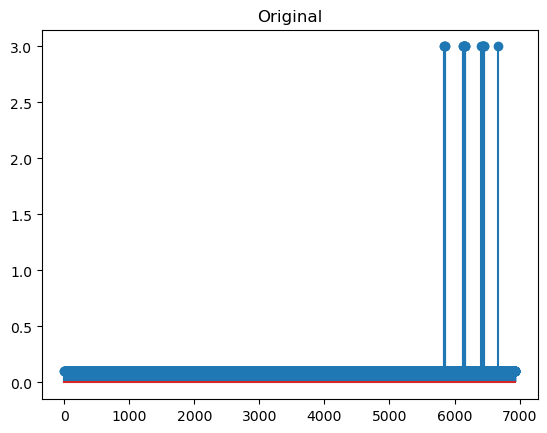

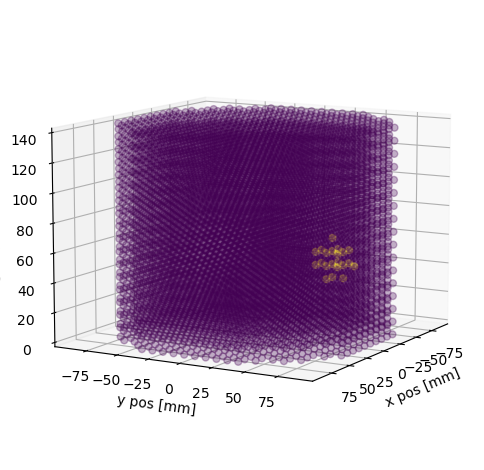

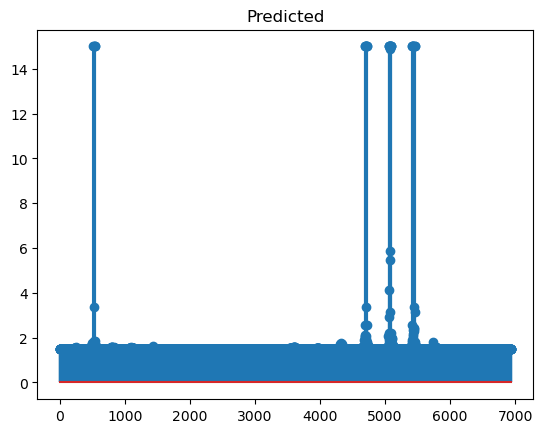

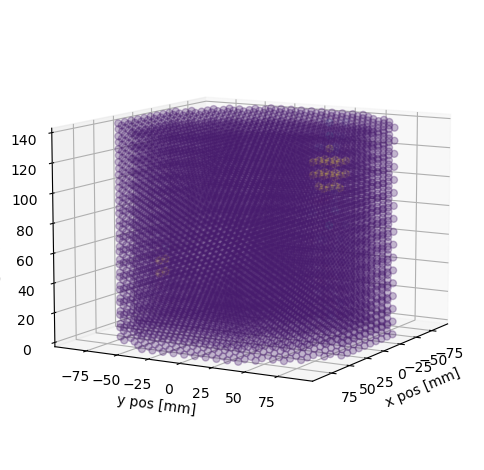

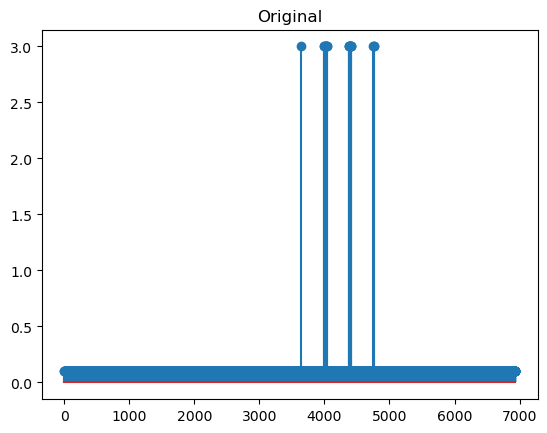

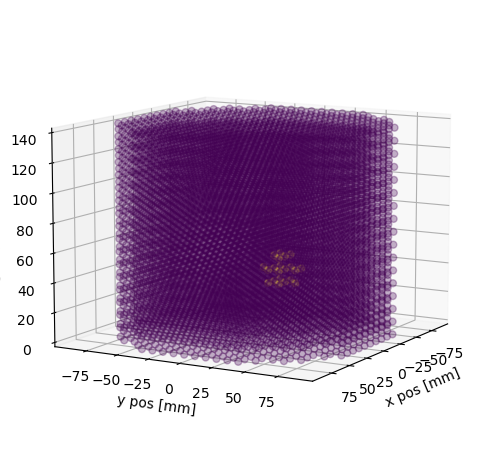

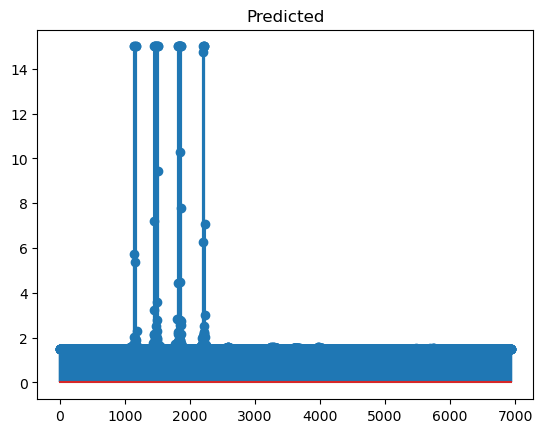

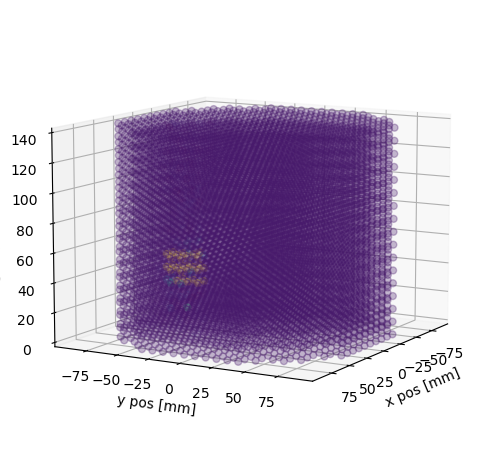

In [79]:
for index in [10, 150, 300, 1000]:
    plt.title("Original")
    plt.stem(Perms_train[index, :])
    plt.show()
    mesh_obj.perm_array = Perms_train[index, :]
    plot_mesh(mesh_obj)

    plt.title("Predicted")
    plt.stem(Perm_pred[index, :])
    plt.show()
    mesh_obj.perm_array = Perm_pred[index, :]
    plot_mesh(mesh_obj)